In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# for feature extraction 

import torch
import numpy as np
from torchvision import transforms
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
import os

# Define the FeatureExtractor class for EfficientNet-B3
class FeatureExtractor:
    def __init__(self):
        # Load EfficientNet-B3 model pre-trained on ImageNet
        self.model = efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)
        # Remove the final fully connected (FC) layer to get features instead of predictions
        self.model = torch.nn.Sequential(*list(self.model.children())[:-1])
        self.model.eval()  # Set model to evaluation mode (disables training-specific behavior like dropout)

        # Define the transformation pipeline to prepare input images for EfficientNet-B3
        self.transform = transforms.Compose([
            transforms.ToPILImage(),  # Convert numpy array to PIL Image
            transforms.Resize((300, 300)),  # Resize image to the input size required by EfficientNet-B3
            transforms.ToTensor(),  # Convert image to a normalized PyTorch tensor
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],  # ImageNet mean for normalization
                std=[0.229, 0.224, 0.225]   # ImageNet std deviation for normalization
            ),
        ])

    def extract(self, images):
        """
        Extract feature representations for a batch of images.
        Args:
            images (numpy.ndarray): Raw images as numpy arrays.
        Returns:
            numpy.ndarray: Extracted feature vectors for all input images.
        """
        features = []
        with torch.no_grad():  # Disable gradient calculation for inference
            for img in images:
                # Apply preprocessing transformations
                img_transformed = self.transform(img)
                img_transformed = img_transformed.unsqueeze(0)  # Add batch dimension to the input tensor
                # Pass the transformed image through the model to extract features
                feature = self.model(img_transformed).squeeze().numpy()
                features.append(feature)  # Collect the feature vector

        # Return all features as a numpy array
        return np.array(features)

# Paths to datasets
train_data_dir = '/content/drive/MyDrive/part_two_dataset/train_data'  # Path to training data
eval_data_dir = '/content/drive/MyDrive/part_two_dataset/eval_data'    # Path to evaluation data

# Instantiate the FeatureExtractor for EfficientNet-B3
extractor = FeatureExtractor()

# Function to process datasets and extract features
def process_datasets(data_dir, prefix, num_datasets, output_dir):
    """
    Processes multiple datasets, extracts features, and saves them.
    Args:
        data_dir (str): Directory containing the datasets.
        prefix (str): Prefix for the dataset filenames (e.g., 'train' or 'eval').
        num_datasets (int): Number of datasets to process.
        output_dir (str): Directory to save the extracted features.
    """
    # Create the output directory if it doesn't already exist
    os.makedirs(output_dir, exist_ok=True)

    # Loop through each dataset by its index
    for i in range(1, num_datasets + 1):
        # Construct the file path for the current dataset
        data_path = os.path.join(data_dir, f"{i}_{prefix}_data.tar.pth")
        # Load the dataset (assumes it's stored in PyTorch's .pth format)
        dataset = torch.load(data_path)
        images = dataset['data']  # Extract images (update 'data' key if your dataset uses a different key)

        print(f"Processing {prefix} dataset {i}...")
        # Extract features from the images using the feature extractor
        features = extractor.extract(images)
        # Construct the output file path and save the features as a .npy file
        # saving the features to further use it for training and testing the model
        output_path = os.path.join(output_dir, f"{i}_{prefix}_features.npy")
        np.save(output_path, features)
        print(f"Saved features for {prefix} dataset {i} to {output_path}")

# Directories for storing extracted features
train_output_dir = '/content/drive/MyDrive/part_two_dataset/eb3_extracted_features/train'
eval_output_dir = '/content/drive/MyDrive/part_two_dataset/eb3_extracted_features/eval'

# Process the training datasets and extract features
process_datasets(train_data_dir, 'train', 10, train_output_dir)

# Process the evaluation datasets and extract features
process_datasets(eval_data_dir, 'eval', 10, eval_output_dir)

In [88]:
# ----------------------------------
# PrototypeClassifier Class
# ----------------------------------
class PrototypeClassifier:
    """
    A simple prototype-based classifier that uses the nearest prototype
    for classification. Each class is represented by a single prototype
    that is updated incrementally during training.
    """

    def __init__(self):
        """
        Initialize the classifier with empty prototypes and class counts.
        """
        self.prototypes = {}  # Dictionary to store prototypes for each class
        self.class_counts = {}  # Dictionary to store the number of samples per class

    def euclidean_distance(self, x, y):
        """
        Calculate the Euclidean distance between two vectors.
        Args:
            x (numpy.ndarray): First vector.
            y (numpy.ndarray): Second vector.
        Returns:
            float: Euclidean distance.
        """
        return np.linalg.norm(x - y)  # Compute the L2 norm of the difference

    def train(self, features, labels):
        """
        Train the classifier by computing and updating class prototypes.
        Args:
            features (numpy.ndarray): Feature vectors for training data.
            labels (numpy.ndarray): Corresponding labels for training data.
        """
        for feature, label in zip(features, labels):  # Iterate over features and labels
            if label not in self.prototypes:
                # Initialize prototype and count for new class
                self.prototypes[label] = feature
                self.class_counts[label] = 1
            else:
                # Update existing prototype by averaging with the new feature
                self.prototypes[label] = (
                    self.prototypes[label] * self.class_counts[label] + feature
                ) / (self.class_counts[label] + 1)
                self.class_counts[label] += 1  # Increment the sample count for the class

    def predict(self, features):
        """
        Predict class labels for a set of feature vectors.
        Args:
            features (numpy.ndarray): Feature vectors.
        Returns:
            numpy.ndarray: Predicted labels.
        """
        predictions = []
        for feature in features:  # Iterate over features
            # Compute distances from the feature to all prototypes
            distances = {
                label: self.euclidean_distance(feature, prototype)
                for label, prototype in self.prototypes.items()
            }
            # Find the label of the nearest prototype
            predictions.append(min(distances, key=distances.get))
        return np.array(predictions)  # Return predictions as a numpy array

    def update_classifier(self, features, pseudo_labels):
        """
        Incrementally update the classifier with new data and pseudo-labels.
        Args:
            features (numpy.ndarray): Feature vectors for the new data.
            pseudo_labels (numpy.ndarray): Pseudo-labels for the data
        """
        for feature, pseudo_label in zip(features, pseudo_labels):  # Iterate over features and pseudo-labels
            if pseudo_label not in self.prototypes:
                # Initialize prototype and count for a new pseudo-class
                self.prototypes[pseudo_label] = feature
                self.class_counts[pseudo_label] = 1
            else:
                # Update prototype for an existing pseudo-class
                self.prototypes[pseudo_label] = (
                    self.prototypes[pseudo_label] * self.class_counts[pseudo_label] + feature
                ) / (self.class_counts[pseudo_label] + 1)
                self.class_counts[pseudo_label] += 1  # Increment the count for the pseudo-class

In [89]:
# ----------------------------------
# Training Features
# ----------------------------------
import time
import os
import numpy as np
from sklearn.metrics import accuracy_score
import pickle

def save_model(model, path):
    """
    Save a model to the specified path using pickle.
    Args:
        model: The model object to save.
        path (str): The path to save the model file.
    """
    with open(path, 'wb') as f:
        pickle.dump(model, f)

def load_model(path):
    """
    Load a model from the specified path using pickle.
    Args:
        path (str): The path of the saved model file.
    Returns:
        Loaded model object.
    """
    with open(path, 'rb') as f:
        return pickle.load(f)

def task1_train_features():
    """
    Train the classifier incrementally on pre-extracted feature datasets (D11 to D20).
    Save each updated model to Google Drive after training and log the time taken for each step.
    """
    # Path to the pre-trained model on D1-D10
    model_path = '/content/drive/MyDrive/eb3_trained_models/f10_features.pkl'

    # Load the pre-trained classifier model
    classifier = load_model(model_path)
    print("Loaded pre-trained model from", model_path)

    # Directory containing pre-extracted training features
    feature_dir = "/content/drive/MyDrive/part_two_dataset/eb3_extracted_features/train"

    # List to store timings for each dataset
    timings = []

    # Loop through feature datasets D11 to D20
    for i in range(11, 21):
        start_time = time.time()  # Start timer for the current training step

        # Load the feature dataset for the current iteration
        feature_path = os.path.join(feature_dir, f"{i - 10}_train_features.npy")
        features = np.load(feature_path)
        # Note: Since labels are unavailable, pseudo-labels will be used for training
        print(f"Dataset {i} does not have labels. Using pseudo-labels for training.")

        # Generate pseudo-labels using the current state of the classifier
        pseudo_labels = classifier.predict(features)

        # Update the classifier incrementally with the new features and pseudo-labels
        classifier.update_classifier(features, pseudo_labels)

        # Save the updated classifier model to Google Drive
        save_path = f"/content/drive/MyDrive/eb3_trained_models/f{i}_features.pkl"
        save_model(classifier, save_path)
        print(f"Trained and saved model f{i}_features.pkl to Google Drive at {save_path}")

        # Calculate and log the time taken for this iteration
        end_time = time.time()
        elapsed_time = end_time - start_time
        timings.append((i, elapsed_time))
        print(f"Time taken to train model f{i}: {elapsed_time:.2f} seconds")

    # Print summary of timings for all datasets
    print("\nTraining Timings:")
    for dataset, timing in timings:
        print(f"Dataset {dataset}: {timing:.2f} seconds")

In [ ]:
# ----------------------------------
# Testing Features
# ----------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

def task1_test_features():
    """
    Evaluate the saved classifiers on pre-extracted test datasets (D1 to D20).
    Log the time taken for each testing step and plot the accuracy matrix.
    """
    # Paths to pre-extracted evaluation features for Part 1 and Part 2 datasets
    feature_dir1 = "/content/drive/MyDrive/part_one_dataset/eb3_extracted_features/eval"
    feature_dir2 = "/content/drive/MyDrive/part_two_dataset/eb3_extracted_features/eval"

    timings = []  # List to store the time taken for testing each model
    accuracy_matrix = np.zeros((10, 20))  # Initialize a 10x20 accuracy matrix

    # Loop through models f11 to f20
    for i in range(11, 21):
        start_time = time.time()  # Start timer for testing the current model

        # Load the trained classifier model f{i}
        model_path = f"/content/drive/MyDrive/eb3_trained_models/f{i}_features.pkl"
        classifier = load_model(model_path)
        print(f"Loaded model f{i} from {model_path}")

        # Evaluate the model on all datasets D1 to D{i}
        for j in range(1, i + 1):
            if j <= 10:
                # Load Part 1 evaluation features and labels
                feature_path = os.path.join(feature_dir1, f"{j}_eval_features.npy")
                labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.pth')['targets']
            else:
                # Load Part 2 evaluation features and labels
                feature_path = os.path.join(feature_dir2, f"{j - 10}_eval_features.npy")
                labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.tar.pth')['targets']

            # Load pre-extracted features
            features = np.load(feature_path)

            # Predict class labels using the current classifier
            predictions = classifier.predict(features)

            # Calculate accuracy for the current dataset and store in the matrix
            accuracy = accuracy_score(labels, predictions) * 100
            accuracy_matrix[i - 11, j - 1] = accuracy
            print(f"Model f{i}, Dataset D{j} - Accuracy: {accuracy:.2f}%")

        # End timer and log the elapsed time for testing the current model
        end_time = time.time()
        elapsed_time = end_time - start_time
        timings.append((i, elapsed_time))
        print(f"Time taken to test model f{i}: {elapsed_time:.2f} seconds")

    # Plot the accuracy matrix as a heatmap
    plt.figure(figsize=(20, 8))
    sns.heatmap(
        accuracy_matrix,
        annot=True,
        fmt=".2f",
        cmap="viridis",
        xticklabels=[f"D{j}" for j in range(1, 21)],  # Dataset labels
        yticklabels=[f"f{i}" for i in range(11, 21)],  # Model labels
    )
    plt.title("Accuracy Matrix for Test Data")
    plt.xlabel("Dataset")
    plt.ylabel("Model")
    plt.tight_layout()
    plt.show()

In [91]:
task1_train_features()

Loaded pre-trained model from /content/drive/MyDrive/eb3_trained_models/f10_features.pkl
Dataset 11 does not have labels. Using pseudo-labels for training.
Trained and saved model f11_features.pkl to Google Drive at /content/drive/MyDrive/eb3_trained_models/f11_features.pkl
Time taken to train model f11: 0.24 seconds
Dataset 12 does not have labels. Using pseudo-labels for training.
Trained and saved model f12_features.pkl to Google Drive at /content/drive/MyDrive/eb3_trained_models/f12_features.pkl
Time taken to train model f12: 0.18 seconds
Dataset 13 does not have labels. Using pseudo-labels for training.
Trained and saved model f13_features.pkl to Google Drive at /content/drive/MyDrive/eb3_trained_models/f13_features.pkl
Time taken to train model f13: 0.23 seconds
Dataset 14 does not have labels. Using pseudo-labels for training.
Trained and saved model f14_features.pkl to Google Drive at /content/drive/MyDrive/eb3_trained_models/f14_features.pkl
Time taken to train model f14: 0.21

Loaded model f11 from /content/drive/MyDrive/eb3_trained_models/f11_features.pkl


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f11, Dataset D1 - Accuracy: 82.92%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f11, Dataset D2 - Accuracy: 84.32%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f11, Dataset D3 - Accuracy: 84.68%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f11, Dataset D4 - Accuracy: 84.00%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f11, Dataset D5 - Accuracy: 84.04%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f11, Dataset D6 - Accuracy: 84.96%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f11, Dataset D7 - Accuracy: 83.36%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f11, Dataset D8 - Accuracy: 84.12%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f11, Dataset D9 - Accuracy: 82.80%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f11, Dataset D10 - Accuracy: 83.76%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f11, Dataset D11 - Accuracy: 66.68%
Time taken to test model f11: 2.47 seconds
Loaded model f12 from /content/drive/MyDrive/eb3_trained_models/f12_features.pkl


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f12, Dataset D1 - Accuracy: 80.48%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f12, Dataset D2 - Accuracy: 82.00%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f12, Dataset D3 - Accuracy: 82.36%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f12, Dataset D4 - Accuracy: 81.24%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f12, Dataset D5 - Accuracy: 81.96%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f12, Dataset D6 - Accuracy: 82.56%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f12, Dataset D7 - Accuracy: 81.36%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f12, Dataset D8 - Accuracy: 81.96%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f12, Dataset D9 - Accuracy: 80.04%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f12, Dataset D10 - Accuracy: 81.68%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f12, Dataset D11 - Accuracy: 64.68%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f12, Dataset D12 - Accuracy: 39.20%
Time taken to test model f12: 3.01 seconds
Loaded model f13 from /content/drive/MyDrive/eb3_trained_models/f13_features.pkl


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f13, Dataset D1 - Accuracy: 80.40%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f13, Dataset D2 - Accuracy: 81.76%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f13, Dataset D3 - Accuracy: 81.88%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f13, Dataset D4 - Accuracy: 81.84%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f13, Dataset D5 - Accuracy: 82.04%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f13, Dataset D6 - Accuracy: 81.80%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f13, Dataset D7 - Accuracy: 80.96%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f13, Dataset D8 - Accuracy: 81.88%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f13, Dataset D9 - Accuracy: 79.92%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f13, Dataset D10 - Accuracy: 81.76%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f13, Dataset D11 - Accuracy: 64.44%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f13, Dataset D12 - Accuracy: 41.28%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f13, Dataset D13 - Accuracy: 71.64%
Time taken to test model f13: 4.87 seconds
Loaded model f14 from /content/drive/MyDrive/eb3_trained_models/f14_features.pkl


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f14, Dataset D1 - Accuracy: 80.68%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f14, Dataset D2 - Accuracy: 82.04%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f14, Dataset D3 - Accuracy: 82.24%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f14, Dataset D4 - Accuracy: 82.24%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f14, Dataset D5 - Accuracy: 82.32%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f14, Dataset D6 - Accuracy: 82.48%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f14, Dataset D7 - Accuracy: 81.40%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f14, Dataset D8 - Accuracy: 82.12%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f14, Dataset D9 - Accuracy: 80.60%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f14, Dataset D10 - Accuracy: 82.12%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f14, Dataset D11 - Accuracy: 65.32%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f14, Dataset D12 - Accuracy: 42.64%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f14, Dataset D13 - Accuracy: 72.60%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f14, Dataset D14 - Accuracy: 79.20%
Time taken to test model f14: 3.08 seconds
Loaded model f15 from /content/drive/MyDrive/eb3_trained_models/f15_features.pkl


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f15, Dataset D1 - Accuracy: 81.00%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f15, Dataset D2 - Accuracy: 82.36%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f15, Dataset D3 - Accuracy: 82.36%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f15, Dataset D4 - Accuracy: 82.68%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f15, Dataset D5 - Accuracy: 82.76%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f15, Dataset D6 - Accuracy: 82.96%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f15, Dataset D7 - Accuracy: 81.68%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f15, Dataset D8 - Accuracy: 82.76%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f15, Dataset D9 - Accuracy: 80.88%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f15, Dataset D10 - Accuracy: 82.76%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f15, Dataset D11 - Accuracy: 66.28%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f15, Dataset D12 - Accuracy: 43.60%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f15, Dataset D13 - Accuracy: 73.28%
Model f15, Dataset D14 - Accuracy: 79.88%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f15, Dataset D15 - Accuracy: 82.32%
Time taken to test model f15: 3.35 seconds
Loaded model f16 from /content/drive/MyDrive/eb3_trained_models/f16_features.pkl


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f16, Dataset D1 - Accuracy: 80.84%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f16, Dataset D2 - Accuracy: 82.24%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f16, Dataset D3 - Accuracy: 82.20%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f16, Dataset D4 - Accuracy: 82.52%
Model f16, Dataset D5 - Accuracy: 82.44%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f16, Dataset D6 - Accuracy: 82.72%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f16, Dataset D7 - Accuracy: 81.92%
Model f16, Dataset D8 - Accuracy: 82.56%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f16, Dataset D9 - Accuracy: 80.60%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f16, Dataset D10 - Accuracy: 82.32%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f16, Dataset D11 - Accuracy: 66.00%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f16, Dataset D12 - Accuracy: 44.40%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f16, Dataset D13 - Accuracy: 72.96%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f16, Dataset D14 - Accuracy: 79.64%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f16, Dataset D15 - Accuracy: 81.84%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f16, Dataset D16 - Accuracy: 66.36%
Time taken to test model f16: 5.39 seconds
Loaded model f17 from /content/drive/MyDrive/eb3_trained_models/f17_features.pkl


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f17, Dataset D1 - Accuracy: 80.80%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f17, Dataset D2 - Accuracy: 82.24%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f17, Dataset D3 - Accuracy: 82.44%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f17, Dataset D4 - Accuracy: 82.64%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f17, Dataset D5 - Accuracy: 82.20%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f17, Dataset D6 - Accuracy: 83.00%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f17, Dataset D7 - Accuracy: 82.00%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f17, Dataset D8 - Accuracy: 82.56%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f17, Dataset D9 - Accuracy: 80.68%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f17, Dataset D10 - Accuracy: 82.36%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f17, Dataset D11 - Accuracy: 65.92%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f17, Dataset D12 - Accuracy: 44.88%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f17, Dataset D13 - Accuracy: 73.20%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f17, Dataset D14 - Accuracy: 79.80%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f17, Dataset D15 - Accuracy: 82.12%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f17, Dataset D16 - Accuracy: 66.84%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f17, Dataset D17 - Accuracy: 74.60%
Time taken to test model f17: 4.75 seconds
Loaded model f18 from /content/drive/MyDrive/eb3_trained_models/f18_features.pkl


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f18, Dataset D1 - Accuracy: 80.68%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f18, Dataset D2 - Accuracy: 82.48%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f18, Dataset D3 - Accuracy: 82.28%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f18, Dataset D4 - Accuracy: 82.72%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f18, Dataset D5 - Accuracy: 82.20%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f18, Dataset D6 - Accuracy: 83.20%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f18, Dataset D7 - Accuracy: 82.20%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f18, Dataset D8 - Accuracy: 82.68%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f18, Dataset D9 - Accuracy: 80.92%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f18, Dataset D10 - Accuracy: 82.56%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f18, Dataset D11 - Accuracy: 66.16%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f18, Dataset D12 - Accuracy: 45.36%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f18, Dataset D13 - Accuracy: 73.32%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f18, Dataset D14 - Accuracy: 79.80%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f18, Dataset D15 - Accuracy: 82.08%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f18, Dataset D16 - Accuracy: 67.44%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f18, Dataset D17 - Accuracy: 74.80%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f18, Dataset D18 - Accuracy: 70.52%
Time taken to test model f18: 4.03 seconds
Loaded model f19 from /content/drive/MyDrive/eb3_trained_models/f19_features.pkl


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f19, Dataset D1 - Accuracy: 80.60%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f19, Dataset D2 - Accuracy: 82.52%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f19, Dataset D3 - Accuracy: 81.96%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f19, Dataset D4 - Accuracy: 82.68%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f19, Dataset D5 - Accuracy: 82.28%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f19, Dataset D6 - Accuracy: 82.96%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f19, Dataset D7 - Accuracy: 81.80%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f19, Dataset D8 - Accuracy: 82.56%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f19, Dataset D9 - Accuracy: 80.64%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f19, Dataset D10 - Accuracy: 82.32%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f19, Dataset D11 - Accuracy: 66.04%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f19, Dataset D12 - Accuracy: 46.08%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f19, Dataset D13 - Accuracy: 73.48%
Model f19, Dataset D14 - Accuracy: 79.44%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f19, Dataset D15 - Accuracy: 82.04%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f19, Dataset D16 - Accuracy: 67.72%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f19, Dataset D17 - Accuracy: 74.64%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f19, Dataset D18 - Accuracy: 70.64%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f19, Dataset D19 - Accuracy: 63.16%
Time taken to test model f19: 5.30 seconds
Loaded model f20 from /content/drive/MyDrive/eb3_trained_models/f20_features.pkl


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f20, Dataset D1 - Accuracy: 80.72%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f20, Dataset D2 - Accuracy: 82.40%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f20, Dataset D3 - Accuracy: 82.20%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f20, Dataset D4 - Accuracy: 82.92%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f20, Dataset D5 - Accuracy: 82.20%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f20, Dataset D6 - Accuracy: 83.12%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f20, Dataset D7 - Accuracy: 81.96%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f20, Dataset D8 - Accuracy: 82.72%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f20, Dataset D9 - Accuracy: 80.76%


<ipython-input-90-b9777eb42adf>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_one_dataset/eval_data/{j}_eval_data.tar.p

Model f20, Dataset D10 - Accuracy: 82.32%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f20, Dataset D11 - Accuracy: 66.48%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f20, Dataset D12 - Accuracy: 46.40%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f20, Dataset D13 - Accuracy: 73.64%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f20, Dataset D14 - Accuracy: 79.72%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f20, Dataset D15 - Accuracy: 82.24%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f20, Dataset D16 - Accuracy: 68.32%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f20, Dataset D17 - Accuracy: 74.84%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f20, Dataset D18 - Accuracy: 71.08%


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

Model f20, Dataset D19 - Accuracy: 63.52%
Model f20, Dataset D20 - Accuracy: 80.76%
Time taken to test model f20: 6.14 seconds


<ipython-input-90-b9777eb42adf>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  labels = torch.load(f'/content/drive/MyDrive/part_two_dataset/eval_data/{j - 10}_eval_data.

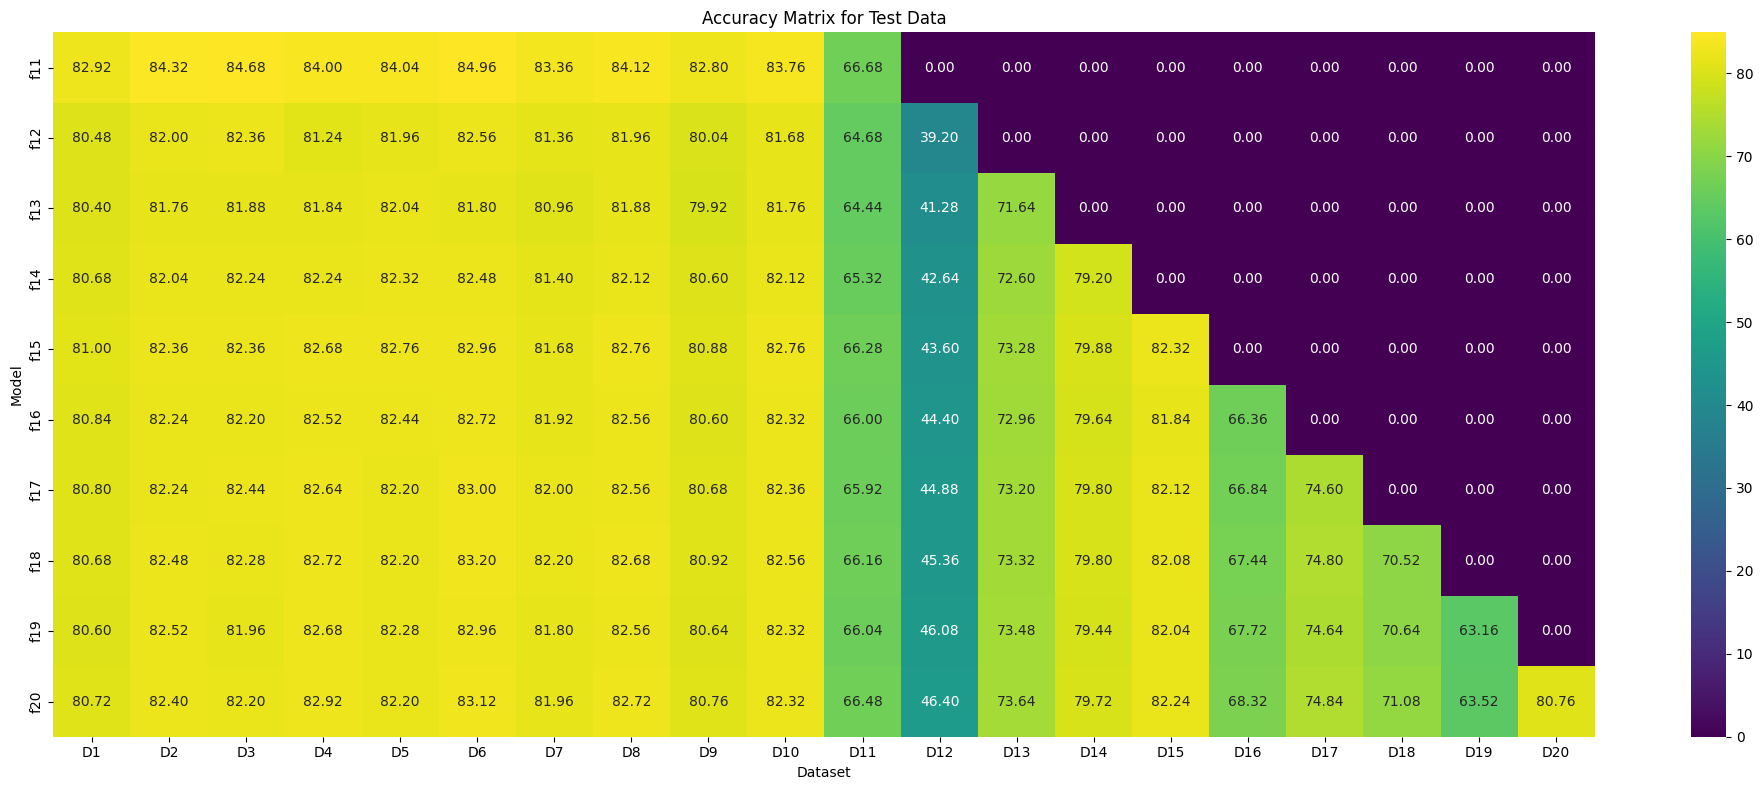

In [92]:
task1_test_features()